Use this notebook to preprocess QPTIFF file inputs. You should generate two files, .TIFF and .TXT, to be used in downstream analysis. TIFF are the multi-layered images, and TXT contains marker and labels information.

Search for "TODO" in this notebook to change accordingly to your specific scenrios.

In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pickle as pkl
import skimage
import yaml
from typing import Union, Optional, Type, Tuple, List, Dict
import sys
# Project Root
# ROOT_DIR = os.path.dirname(os.path.abspath(__file__)) 
# used for searching packages and functions
ROOT_DIR = os.path.dirname(sys.path[0])
sys.path.append(ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, 'image_cytof'))
from cytof.hyperion_preprocess import cytof_read_data_roi
from cytof.utils import save_multi_channel_img, check_feature_distribution

/project/DPDS/Xiao_lab/shared/deep_learning_SW_RR/envs/cytof-notebook/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set Parameters
class SetParameters():
    def __init__(self, 
                 filename: str, 
                 outdir: str, 
                 label_marker_file: Optional[str] = None, 
                 slide: Optional[str] = 'slide1', 
                 roi: Optional[str] = 'roi1', 
                 quality_control_thres: Optional[int] = 50,
                 channels_remove: Optional[List] = None, 
                 channels_dict: Optional[Dict] = None,
                 use_membrane: Optional[bool] = True,
                 cell_radius: Optional[int] = 5, 
                 normalize_qs: Optional[List[int]] = [75, 99]):
        
        self.filename = filename
        self.outdir   = outdir
        self.slide    = slide
        self.roi      = roi
        self.quality_control_thres = quality_control_thres
        self.label_marker_file     = label_marker_file
        self.channels_remove = channels_remove if channels_remove is not None else []
        self.channels_dict   = channels_dict if channels_dict is not None else {}
        self.use_membrane    = use_membrane
        self.cell_radius     = cell_radius
        self.normalize_qs    = normalize_qs




In [3]:
params = SetParameters(
    #TODO: change filename here
    filename='/project/DPDS/Xiao_lab/shared/lcai/Ling-Ivan/component_tiff/phenochart/TP00899-T0-S1-1_Scan1.qptiff',
    outdir="../test_out/tiffs/single_roi", 
    slide="your_slide_name", #TODO
    roi="your_roi_name", #TODO
)

## Read and preprocess data

#### 1. read data: from a .tiff image

In [4]:
cytof_img, _ = cytof_read_data_roi(params.filename, slide=params.slide, roi=params.roi)

In [5]:
from xml.etree import ElementTree
from tifffile import TiffFile

markers = []

# extracts layer name from QPTIFF files
# ref: https://stackoverflow.com/questions/69756828/extract-channel-names-from-a-multi-channel-image
with TiffFile(params.filename) as tif:
    for page in tif.series[0].pages:
        markers.append(ElementTree.fromstring(page.description).find('Name').text)

print(markers)

['DAPI', 'Opal 570', 'Opal 480', 'Opal 620', 'Sample AF', 'Opal 520']


## Visualize images

In [6]:
# select markers to visualize
marker = 'DAPI' #TODO
assert marker in markers, f'marker {marker} not in option {markers}'

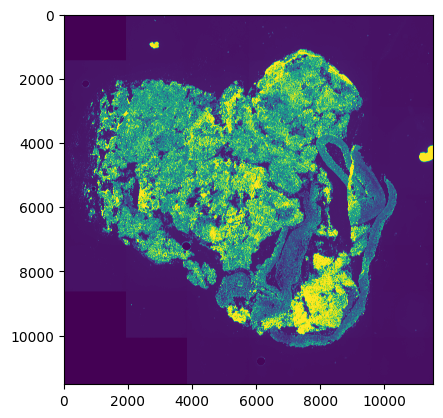

In [7]:
image = cytof_img.image.copy()

# visualize one marker of the entire slide
%matplotlib inline
plt.imshow(image[..., markers.index(marker)])

## export for web app (.TIFF + .TXT)

TIFF is used as raw image input, and TXT contains the label marker information

### TXT file helper

In [8]:
print(markers)

['DAPI', 'Opal 570', 'Opal 480', 'Opal 620', 'Sample AF', 'Opal 520']


In [9]:
#TODO: REQUIRED - label the extracted marker from the QPTIFF file
labels = ['DNA', 'MCT1', 'CD8a', 'MCT4', 'nan', 'CD31']

assert len(labels) == len(markers), 'length of label and marker array has to match!'

**Use the following output as a guide to fill out the label marker file (make sure the format is consistent with the sample file)**

In [15]:
print('labels:', labels, '\nmarkers:', markers)

labels: ['DNA', 'MCT1', 'CD8a', 'MCT4', 'nan', 'CD31'] 
markers: ['DAPI', 'Opal 570', 'Opal 480', 'Opal 620', 'Sample AF', 'Opal 520']


### TIFF file helper

In [11]:
labels_markers = {'labels': labels, 'markers': markers}
labels_markers

{'labels': ['DNA', 'MCT1', 'CD8a', 'MCT4', 'nan', 'CD31'],
 'markers': ['DAPI',
  'Opal 570',
  'Opal 480',
  'Opal 620',
  'Sample AF',
  'Opal 520']}

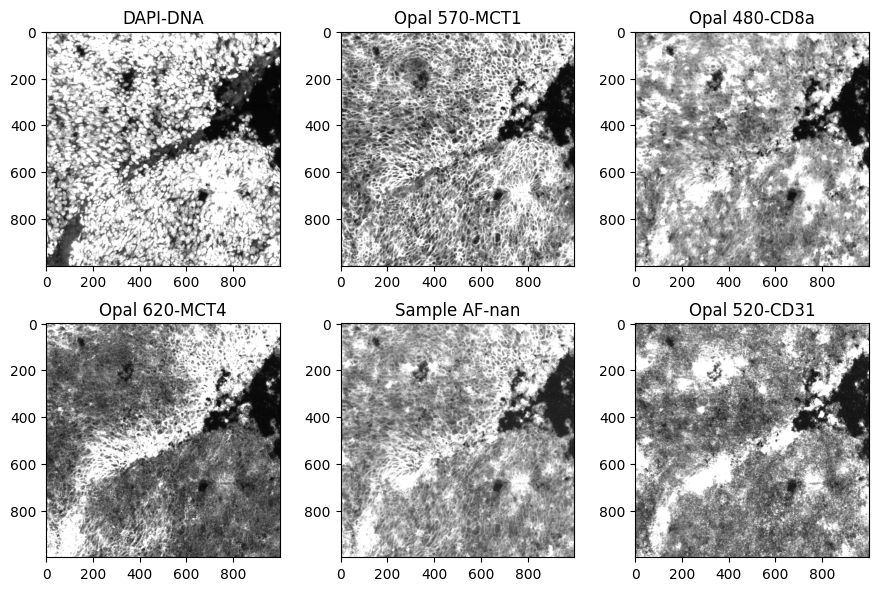

In [12]:
# sets self.channels, self.labels, self.markers
cytof_img.set_markers(**labels_markers)

%matplotlib inline
#TODO: change xlim, ylim to capture desired region
xlim=[4000, 5000]
ylim=[4000, 5000]
cytof_img.check_channels(channels=None, xlim=xlim, ylim=ylim, ncols=3, vis_q=0.9, colorbar=False)

In [13]:
#TODO: remove unwanted channels, if necessary
cytof_img.remove_special_channels(['Sample AF-nan'])

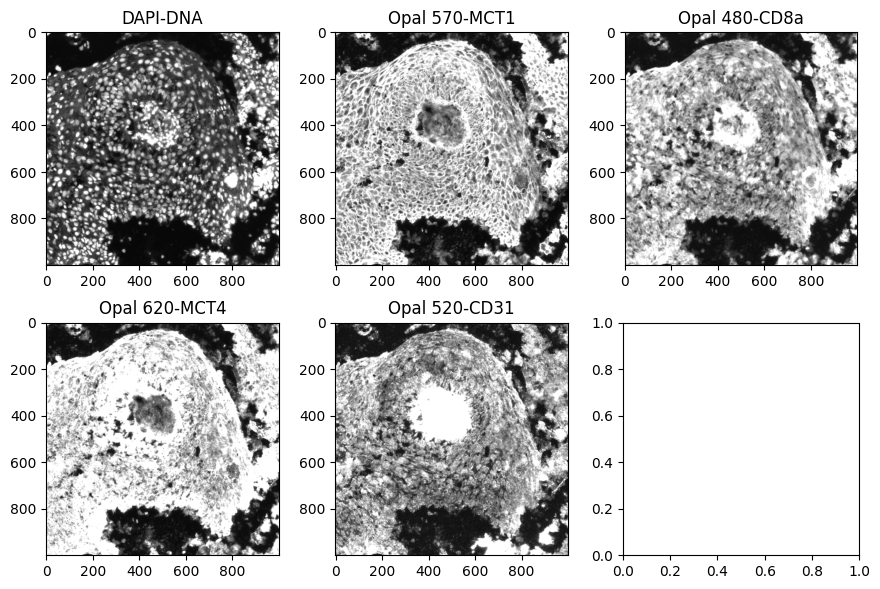

In [14]:
# visualize the channels again
xlim=[5000, 6000]
ylim=[8000, 9000]
cytof_img.check_channels(channels=None, xlim=xlim, ylim=ylim, ncols=3, vis_q=0.9, colorbar=False)

In [17]:
# modify the image here
cropped_image = cytof_img.image[xlim[0]:xlim[1], ylim[0]:ylim[1], :]

**Use the following code to store the ROI in TIFF**

In [18]:
# verify number of layers, image size is correct for output
print(cropped_image.shape)

# skimage.io.imsave('test2.tiff', cropped_image)

(1000, 1000, 5)
